In fully connected neural networks, weights are not shared across neighbouring regions, i.e there is a single weight value which is applied on a single pixel value whereas in a conv neural net, a convolution is applied. This means that the weights of nearby regions influence the output from each layer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function
import torch
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from IPython.display import clear_output
import time

images = np.load('images.npy')
labels = np.load('labels.npy')
num_images,height,width = np.shape(images)
images = images.astype(float)
HEIGHT = images.shape[1]
WIDTH = images.shape[2]
images = np.reshape(images,(num_images,height*width))



labels = labels.astype(int)



x_valid = images[45000:50000][:]

y_valid = labels[45000:50000]


x_train = images[0:45000][:]

y_train = labels[0:45000]



train_seqs = x_train
train_labels = y_train

val_seqs = x_valid
val_labels = y_valid


#constants
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 2000
batch_size = 10;



In [2]:
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(16, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

In [3]:
model = TooSimpleConvNN()

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
def train(batch_size):
    #model.train() puts our model in train mode, which can require different behaviour than eval mode (for example
    #in the case of dropout
    #model.train()
    #i is a 1 dimensional array with shape[batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [6]:
def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.float32)))
    y_hat_ = model(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
    

In [7]:
def approx_val_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(val_labels.astype(np.float32)))
    y_hat_ = model(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
    

In [8]:
def accuracy(y,y_hat):
    correct = np.count_nonzero(y_hat.data.numpy()==y.data.numpy())
    return correct/y.data.shape[0]

In [9]:
#time
t = time.time()
train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))
        
elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 24.10 23.84
   100 37.20 37.66
   200 39.90 42.12
   300 55.80 53.72
   400 44.40 42.32
   500 54.70 55.30
   600 58.60 59.80
   700 60.00 59.80
   800 63.10 63.44
   900 61.20 61.20
  1000 67.00 67.72
  1100 66.40 68.24
  1200 65.00 66.04
  1300 67.60 69.56
  1400 69.30 69.78
  1500 69.90 72.00
  1600 70.70 72.82
  1700 72.20 72.04
  1800 72.40 74.60
  1900 73.70 74.70
Total training time approx. = 27.862809896469116 secs


average accuracy =  0.5966


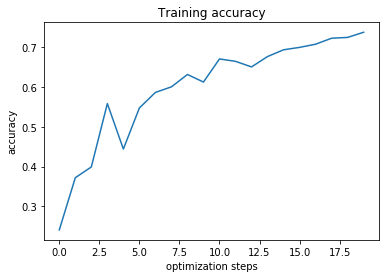

In [10]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.60335


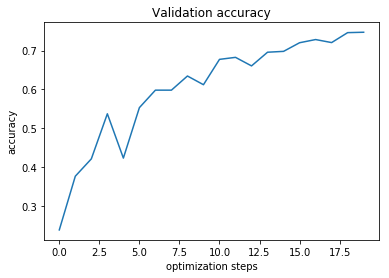

In [11]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [12]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.737 for 2000 optimization steps
Max validation accuracy= 0.747 for 2000 optimization steps
batch_size= 10
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 27.862809896469116 secs


In [13]:
#to maximize accuracy
for m in model.children():
    m.reset_parameters()

#constant parameters
NUM_OPT_STEPS = 5000
batch_size = 256;

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#time
t = time.time()
#training
train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))

elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 19.90 19.66
   100 36.30 38.28
   200 55.30 54.62
   300 62.60 63.90
   400 60.70 61.28
   500 63.30 63.74
   600 68.80 68.48
   700 71.60 71.22
   800 72.00 72.78
   900 76.50 73.12
  1000 77.80 75.12
  1100 76.70 73.48
  1200 75.20 74.96
  1300 73.60 77.08
  1400 77.80 77.12
  1500 78.70 77.70
  1600 76.50 75.98
  1700 78.50 78.68
  1800 79.10 77.28
  1900 81.40 79.56
  2000 79.90 79.46
  2100 80.40 79.96
  2200 79.70 78.50
  2300 81.40 78.92
  2400 78.00 80.74
  2500 77.00 79.90
  2600 82.30 79.06
  2700 79.30 80.68
  2800 81.10 79.62
  2900 82.60 81.46
  3000 82.10 81.18
  3100 81.50 81.38
  3200 84.50 82.16
  3300 82.60 82.54
  3400 80.00 82.40
  3500 80.60 80.70
  3600 80.20 81.58
  3700 81.10 81.40
  3800 82.60 83.12
  3900 80.90 82.12
  4000 82.60 82.48
  4100 83.50 82.98
  4200 81.80 83.08
  4300 82.80 83.30
  4400 81.10 81.72
  4500 82.90 83.10
  4600 84.30 82.70
  4700 83.70 83.08
  4800 80.50 81.36
  4900 84.00 84.34
Total training time approx. = 493.95350217819214 s

average accuracy =  0.76692


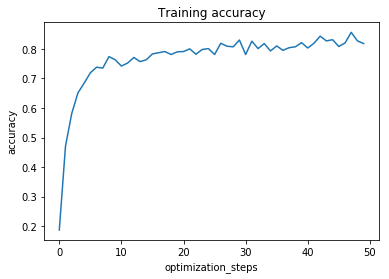

In [17]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.769808


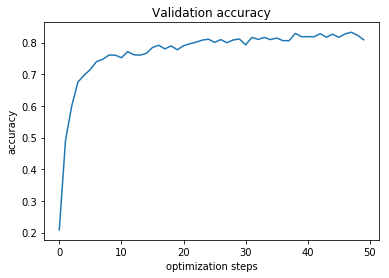

In [16]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [15]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.856 at 4700 optimization steps
Max validation accuracy= 0.856 at 4700 optimization steps
batch_size= 256
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 474.90893816947937 secs
